In [ ]:
""" This notebook contains NLP model experimentation"""
import pandas as pd
import tensorflow as tf
import numpy as np
import time

from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import tensorflow_hub as hub

from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get Data

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-04-02 00:11:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-02 00:11:18 (37.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-04-02 00:11:37--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.207, 173.194.195.207, 173.194.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.02s   

2024-04-02 00:11:38 (23.8 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
# Turn .csv files into pandas DataFrame's
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
test_df.head()


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df.target.value_counts()


0    4342
1    3271
Name: target, dtype: int64

Split Training and Validation Sets

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:

# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Text Preprocessing

**Tokenization** - Mapping from word/char/sub-word to numerical value.  

**Stemming** - Reducing words to root form.

**Lemmatization** - Similar to stemming but considers the context.



In [ ]:
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [ ]:

# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:

# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:

# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
@PBohanna Probably a dead boring 1st hour and a half after the pandemonium of the last Test..... #justaguess      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[9893,  672,    3,  115,    1, 1337, 1132,    7,    3,  575,   43,
           2,  502,    6,    2]])>

In [ ]:

# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


# Word Embeddings
**Embeddings** - An embedding is a rep. of language which can be learned (ex. feature vector). Example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112] where the feature vector size is tuneable

Also, a word representation that allows words with similar meanings to have similar representations; key methods include Word2Vec, GloVe, and FastText.

In [ ]:
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed


Original text:
I liked a @YouTube video http://t.co/43sXG9Z6xh TREMOR IS NO JOKE!! [TREMOR DLC] [FATALITIES/X-RAY]      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02619331, -0.01367794,  0.0448654 , ...,  0.01503653,
         -0.01359696, -0.02406622],
        [ 0.0485234 ,  0.03316988,  0.04374707, ...,  0.00625994,
         -0.02296002,  0.02656804],
        [-0.03521113,  0.00734498, -0.03166634, ...,  0.03382749,
         -0.02880077,  0.0330272 ],
        ...,
        [ 0.01983789, -0.02399758,  0.0110661 , ...,  0.01736838,
          0.00739496,  0.00984377],
        [ 0.02170867, -0.01312228, -0.00883342, ...,  0.01045974,
         -0.01005391, -0.01328592],
        [ 0.02170867, -0.01312228, -0.00883342, ...,  0.01045974,
         -0.01005391, -0.01328592]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0]


<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.02619331, -0.01367794,  0.0448654 ,  0.02852973,  0.01279994,
        0.03919848,  0.01438911,  0.02402638,  0.00705371,  0.01780485,
        0.00287246,  0.04061819,  0.00985317,  0.0155477 ,  0.00780035,
        0.01148053,  0.00189829, -0.03744718, -0.01207205, -0.00455561,
       -0.00668367, -0.02539872, -0.01051315, -0.02250626,  0.0276932 ,
       -0.01808306,  0.03283974, -0.00784802, -0.0325724 , -0.01689781,
       -0.00721677, -0.02684244,  0.00025084, -0.02699517, -0.00484675,
        0.00152291,  0.03814283, -0.0140559 ,  0.04109119, -0.00442121,
       -0.04588633, -0.00604064,  0.02715403, -0.02020239, -0.02234983,
        0.01269746,  0.03017085,  0.00595393,  0.03621582, -0.02373411,
        0.00890632,  0.03948573, -0.04462897,  0.01671925,  0.02253245,
        0.00024878, -0.01936911, -0.02749817, -0.02093231, -0.00607785,
        0.03305216,  0.02160427,  0.02650216,  0.00370405,  0.02764981,
        0.023973

In [ ]:
# Sample sentences
sentences = [
    ['word', 'embeddings', 'are', 'a', 'type', 'of', 'word', 'representation'],
    ['they', 'allow', 'words', 'with', 'similar', 'meanings', 'to', 'have', 'similar', 'representations'],
    ['key', 'methods', 'include', 'word2vec', 'glove', 'and', 'fasttext']
]

w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
glove_file = 'glove.6B.100d.txt'
word2vec_glove_file = 'glove.6B.100d.word2vec.txt'
# glove2word2vec(sentences, word2vec_glove_file)
# glove_model = KeyedVectors.load_word2vec_format(word2vec_glove_file, binary=False)

# fasttext_file = 'wiki.en.vec'
# fasttext_model = KeyedVectors.load_word2vec_format(fasttext_file, binary=False)

word_embeddings_w2v = w2v_model.wv
vector_word2vec = word_embeddings_w2v['word']
# vector_glove = glove_model['word']

# vector_fasttext = fasttext_model['word']

similar_words_w2v = w2v_model.wv.most_similar('word')
print(similar_words_w2v)
# similar_words_glove = glove_model.most_similar('word')
# similar_words_fasttext = fasttext_model.most_similar('word')

[('fasttext', 0.18858347833156586), ('and', 0.16072256863117218), ('representations', 0.15925443172454834), ('word2vec', 0.1372579038143158), ('meanings', 0.12305273860692978), ('have', 0.0854613184928894), ('words', 0.06800209730863571), ('of', 0.03364872932434082), ('to', 0.02231444977223873), ('are', 0.009505496360361576)]


# Feature Extraction
Convert text data into a format that can be understood by machine learning algorithms. Key methods include Bag-of-words (BoW), Term Frequency-Inverse Document Frequency (TF-IDF), and n-grams.

In [ ]:

corpus = [
    'Bag-of-words is a technique for feature extraction from text data.',
    'TF-IDF stands for Term Frequency-Inverse Document Frequency.',
    'N-grams are contiguous sequences of n items from a given text.'
]

# Bag-of-Words (BoW)
bow_vectorizer = CountVectorizer()
bow_features = bow_vectorizer.fit_transform(corpus)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(corpus)

# N-grams (bi-grams)
ngram_vectorizer = CountVectorizer(ngram_range=(2, 2))
ngram_features = ngram_vectorizer.fit_transform(corpus)

print("N-grams (bi-grams) feature matrix:")
print(ngram_features.toarray())

N-grams (bi-grams) feature matrix:
[[0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1]
 [0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0]
 [1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0]]


## Model Experimentation

### Baseline Model : Bayesian

In [ ]:
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:

baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
SAVE_DIR = "model_logs"

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

### Model 1: Simple Dense Model

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240402-001146
Epoch 1/5
215/215 [==============================] - 17s 66ms/step - loss: 0.6108 - accuracy: 0.6923 - val_loss: 0.5367 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 14s 65ms/step - loss: 0.4422 - accuracy: 0.8192 - val_loss: 0.4694 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 14s 67ms/step - loss: 0.3472 - accuracy: 0.8606 - val_loss: 0.4590 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 7s 32ms/step - loss: 0.2856 - accuracy: 0.8918 - val_loss: 0.4638 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 8s 36ms/step - loss: 0.2387 - accuracy: 0.9118 - val_loss: 0.4761 - val_accuracy: 0.7861


In [ ]:
model_1.evaluate(val_sentences, val_labels)


24/24 [==============================] - 0s 4ms/step - loss: 0.4761 - accuracy: 0.7861


[0.4760986566543579, 0.7860892415046692]

In [ ]:
embedding.weights


[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00317654, -0.03175117,  0.00956257, ..., -0.00345722,
         -0.02869722,  0.00613138],
        [ 0.01378111, -0.02896047,  0.01647445, ..., -0.00565998,
          0.00150251,  0.01416693],
        [ 0.02945375, -0.06919856,  0.03287233, ...,  0.0403207 ,
         -0.02929477,  0.05368619],
        ...,
        [-0.014456  ,  0.03325728,  0.02684665, ...,  0.03481572,
         -0.01891661, -0.04786307],
        [-0.06140312, -0.05712024,  0.03412978, ...,  0.06627402,
          0.00906638,  0.04867005],
        [-0.01981809, -0.02892058,  0.09019018, ...,  0.08486102,
         -0.09086722,  0.09745828]], dtype=float32)>]

In [ ]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 2ms/step


array([[0.40094793],
       [0.7448928 ],
       [0.9978538 ],
       [0.10776176],
       [0.10995304],
       [0.9333035 ],
       [0.9197185 ],
       [0.99295735],
       [0.9698732 ],
       [0.26407552]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:

# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [ ]:
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [ ]:

# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [ ]:

# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
model_1.summary()


Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Get the weight matrix of embedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)




### Recurrent Neural Networks (RNN's) Experimentation

Sequence Based Problems:
1.   One to one: 1 input, 1 output, ex. image classification.
2.   One to many: 1 input, many outputs, ex. image captions.
3.   Many to one: many inputs, 1 outputs, ex. text classification
4.   Many to many: many inputs, many outputs, ex. machine translation or speech to text

Most Common RNNs
*   Long short-term memory cells (LSTMs).
*   Gated recurrent units (GRUs).
*   Bidirectional RNN's

### Model 2: LSTM - Long Short Term Memory Cells

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)


In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()


Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])


Saving TensorBoard log files to: model_logs/LSTM/20240402-001313
Epoch 1/5
215/215 [==============================] - 15s 52ms/step - loss: 0.5074 - accuracy: 0.7478 - val_loss: 0.4527 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 11s 49ms/step - loss: 0.3161 - accuracy: 0.8720 - val_loss: 0.5122 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 11s 51ms/step - loss: 0.2209 - accuracy: 0.9167 - val_loss: 0.5723 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 11s 53ms/step - loss: 0.1585 - accuracy: 0.9456 - val_loss: 0.6009 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 16s 72ms/step - loss: 0.1114 - accuracy: 0.9603 - val_loss: 0.8175 - val_accuracy: 0.7559


In [ ]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 1s 11ms/step


((762, 1),
 array([[0.00587604],
        [0.7594089 ],
        [0.99900407],
        [0.03649148],
        [0.00557875],
        [0.9992826 ],
        [0.7790641 ],
        [0.99965787],
        [0.9992385 ],
        [0.51146066]], dtype=float32))

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:

# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.59055118110236,
 'precision': 0.7562023016353725,
 'recall': 0.7559055118110236,
 'f1': 0.75433369124314}

In [ ]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.59, Difference: -3.67
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.03


### Model 3: GRU - Gated recurrent units

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")


In [ ]:

# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:

# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20240402-001441
Epoch 1/5
215/215 [==============================] - 15s 50ms/step - loss: 0.5263 - accuracy: 0.7262 - val_loss: 0.4542 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 10s 49ms/step - loss: 0.3192 - accuracy: 0.8680 - val_loss: 0.4884 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 13s 60ms/step - loss: 0.2169 - accuracy: 0.9188 - val_loss: 0.5599 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 10s 48ms/step - loss: 0.1544 - accuracy: 0.9470 - val_loss: 0.6343 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 9s 44ms/step - loss: 0.1170 - accuracy: 0.9594 - val_loss: 0.6224 - val_accuracy: 0.7703


In [ ]:

# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]


24/24 [==============================] - 1s 9ms/step


((762, 1),
 array([[0.3796098 ],
        [0.90202093],
        [0.9965024 ],
        [0.1134285 ],
        [0.01460312],
        [0.99256366],
        [0.77063364],
        [0.99793863],
        [0.9974338 ],
        [0.37288305]], dtype=float32))

In [ ]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7701965974536404,
 'recall': 0.7703412073490814,
 'f1': 0.7694283709964855}

In [ ]:

# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 4: Bidirectional RNNs


In [ ]:
tf.random.set_seed(42)
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [ ]:

# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:

# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [ ]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20240402-001632
Epoch 1/5
215/215 [==============================] - 28s 97ms/step - loss: 0.5115 - accuracy: 0.7430 - val_loss: 0.4588 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 16s 75ms/step - loss: 0.3135 - accuracy: 0.8726 - val_loss: 0.5276 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 13s 60ms/step - loss: 0.2117 - accuracy: 0.9174 - val_loss: 0.5689 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 18s 82ms/step - loss: 0.1454 - accuracy: 0.9511 - val_loss: 0.6574 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 13s 62ms/step - loss: 0.1035 - accuracy: 0.9645 - val_loss: 0.6922 - val_accuracy: 0.7730


In [ ]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.02214845],
       [0.88600045],
       [0.9994473 ],
       [0.11130801],
       [0.00539363],
       [0.99702305],
       [0.9707075 ],
       [0.9994474 ],
       [0.9996313 ],
       [0.12129357]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.29658792650919,
 'precision': 0.7731790030340066,
 'recall': 0.7729658792650919,
 'f1': 0.7717707641179984}

In [ ]:

# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 77.30, Difference: -1.97
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


# Convolutional Neural Networks for Text


In [ ]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]


(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.03625336, -0.03446066, -0.05021206, ..., -0.0178065 ,
           0.02284522,  0.03526678],
         [-0.03159752, -0.0655195 ,  0.03710155, ...,  0.06602295,
          -0.00623347,  0.02642621],
         [-0.04758833, -0.00613463, -0.01875434, ...,  0.03011706,
          -0.04145961,  0.04695335],
         ...,
         [ 0.00317654, -0.03175117,  0.00956257, ..., -0.00345722,
          -0.02869722,  0.00613138],
         [ 0.00317654, -0.03175117,  0.00956257, ..., -0.00345722,
          -0.02869722,  0.00613138],
         [ 0.00317654, -0.03175117,  0.00956257, ..., -0.00345722,
          -0.02869722,  0.00613138]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[8.1737610e-03, 3.0467970e-02, 9.3377039e-02, 2.0829370e-02,
          0.0000000e+00, 9.4901286e-02, 0.0000000e+00, 0.0000000e+00,
          0.0000000e+00, 7.2001368e-02, 0.0000000e+00, 5.3405926e-02,
          6.1119036e-03,

# Model 5: Conv1D

In [ ]:
tf.random.set_seed(42)
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240402-011118
Epoch 1/5
215/215 [==============================] - 10s 40ms/step - loss: 0.5651 - accuracy: 0.7154 - val_loss: 0.4714 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 14s 64ms/step - loss: 0.3408 - accuracy: 0.8622 - val_loss: 0.4725 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 11s 53ms/step - loss: 0.2135 - accuracy: 0.9212 - val_loss: 0.5383 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 12s 54ms/step - loss: 0.1388 - accuracy: 0.9536 - val_loss: 0.6075 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0980 - accuracy: 0.9664 - val_loss: 0.6701 - val_accuracy: 0.7835


In [ ]:

# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 5ms/step


array([[0.59149206],
       [0.6850218 ],
       [0.99971807],
       [0.03465141],
       [0.0019114 ],
       [0.99214447],
       [0.93141806],
       [0.9981354 ],
       [0.99980414],
       [0.5063897 ]], dtype=float32)

In [ ]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.34645669291339,
 'precision': 0.785851650078301,
 'recall': 0.7834645669291339,
 'f1': 0.7813141680786296}

In [ ]:

# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 78.35, Difference: -0.92
Baseline precision: 0.81, New precision: 0.79, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


Using Pretrained Embeddings (transfer learning for NLP)


### Model 6: TensorFlow Hub Pretrained Sentence Encoder


In [ ]:

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:

# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [ ]:

# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240402-011636
Epoch 1/5
215/215 [==============================] - 11s 28ms/step - loss: 0.5058 - accuracy: 0.7854 - val_loss: 0.4499 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4149 - accuracy: 0.8142 - val_loss: 0.4380 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4002 - accuracy: 0.8228 - val_loss: 0.4335 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3926 - accuracy: 0.8267 - val_loss: 0.4285 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3862 - accuracy: 0.8289 - val_loss: 0.4298 - val_accuracy: 0.8150


In [ ]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 2s 27ms/step


array([[0.15173145],
       [0.7470252 ],
       [0.9860733 ],
       [0.19904141],
       [0.7285006 ],
       [0.68772936],
       [0.9812298 ],
       [0.9753811 ],
       [0.9254341 ],
       [0.09221412]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:

# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results


{'accuracy': 81.49606299212599,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598,
 'f1': 0.8134357776936025}

In [ ]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.50, Difference: 2.23
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data




In [ ]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [ ]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [ ]:
# Check the number of targets in our subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()


0    415
1    271
dtype: int64

In [ ]:

# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20240402-012631
Epoch 1/5
22/22 [==============================] - 9s 103ms/step - loss: 0.6704 - accuracy: 0.6574 - val_loss: 0.6475 - val_accuracy: 0.7231
Epoch 2/5
22/22 [==============================] - 1s 30ms/step - loss: 0.5923 - accuracy: 0.8032 - val_loss: 0.5867 - val_accuracy: 0.7428
Epoch 3/5
22/22 [==============================] - 1s 31ms/step - loss: 0.5119 - accuracy: 0.8222 - val_loss: 0.5338 - val_accuracy: 0.7703
Epoch 4/5
22/22 [==============================] - 1s 31ms/step - loss: 0.4483 - accuracy: 0.8411 - val_loss: 0.5045 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4062 - accuracy: 0.8469 - val_loss: 0.4891 - val_accuracy: 0.7795


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 2s 33ms/step


array([[0.28521758],
       [0.8123465 ],
       [0.9189063 ],
       [0.31403652],
       [0.56885374],
       [0.84728384],
       [0.8092124 ],
       [0.8550932 ],
       [0.84355104],
       [0.14054312]], dtype=float32)

In [ ]:

# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'precision': 0.7845315890997154,
 'recall': 0.7795275590551181,
 'f1': 0.7762737227239795}

# Model Evaluation and Validation

In [ ]:

# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,75.590551,0.756202,0.755906,0.754334
gru,77.034121,0.770197,0.770341,0.769428
bidirectional,77.296588,0.773179,0.772966,0.771771
conv1d,78.346457,0.785852,0.783465,0.781314
tf_hub_sentence_encoder,81.496063,0.817255,0.814961,0.813436
tf_hub_10_percent_data,77.952756,0.784532,0.779528,0.776274


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

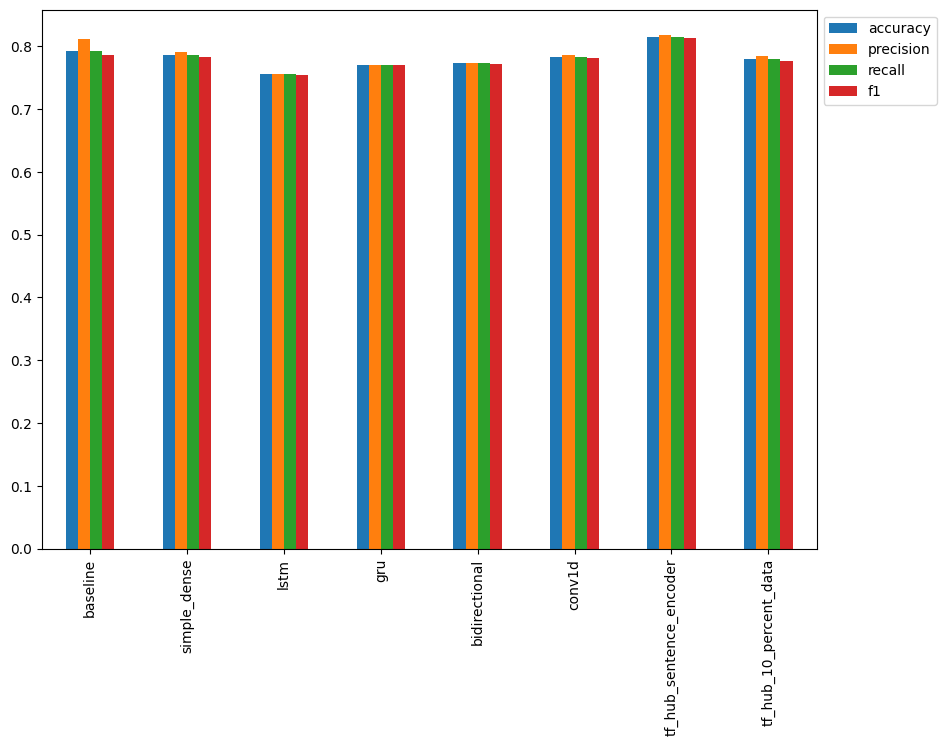

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

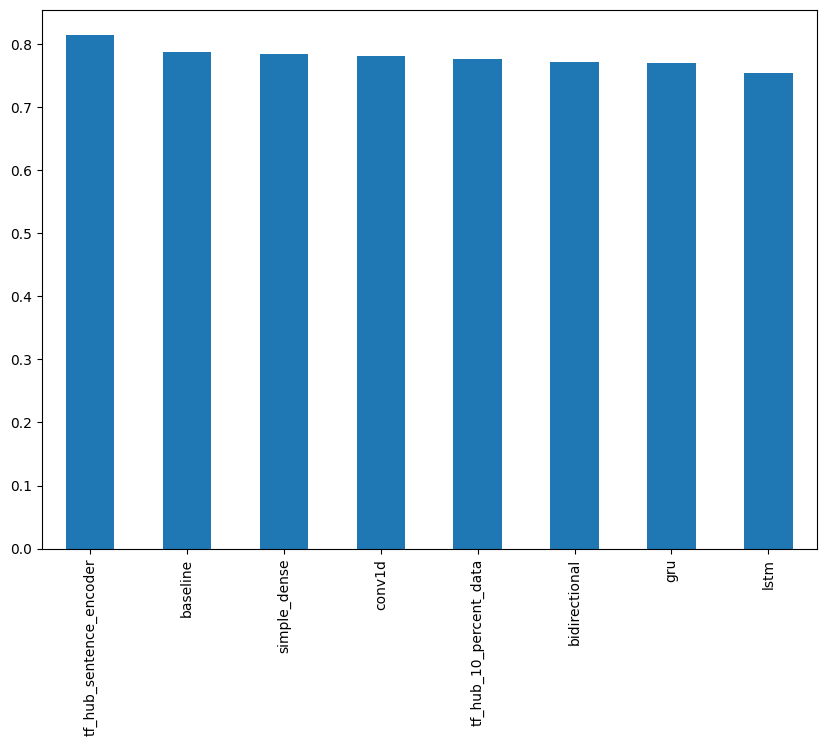

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [ ]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.4776902887139,
 'precision': 0.7844679626314316,
 'recall': 0.7847769028871391,
 'f1': 0.7844262888191608}

In [ ]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [ ]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [ ]:
all_model_results


,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.755906,0.756202,0.755906,0.754334
gru,0.770341,0.770197,0.770341,0.769428
bidirectional,0.772966,0.773179,0.772966,0.771771
conv1d,0.783465,0.785852,0.783465,0.781314
tf_hub_sentence_encoder,0.814961,0.817255,0.814961,0.813436
tf_hub_10_percent_data,0.779528,0.784532,0.779528,0.776274
ensemble_results,0.784777,0.784468,0.784777,0.784426


In [ ]:
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})


In [ ]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [ ]:
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)


24/24 [==============================] - 1s 15ms/step - loss: 0.4298 - accuracy: 0.8150


[0.42979875206947327, 0.8149606585502625]

### Speed/Score Trade Off

In [ ]:

def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

In [ ]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred